In [1]:
# nbi:hide_in
# nbi:hide_out
import nbinteract as nbi

import pandas as pd
import numpy as np

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import interact, interact_manual

'''
Imports para visualização
'''
import seaborn as sns
import squarify
from seaborn import countplot

# -- Matplotlib --
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import matplotlib.dates as dates

In [2]:
# nbi:hide_in
# nbi:hide_out
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# -- Prophet --
from fbprophet import Prophet
# - Performace
from fbprophet.diagnostics import cross_validation, performance_metrics
# - Plot
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
# - Remove Warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
warnings.filterwarnings("ignore")

In [3]:
# nbi:hide_in
# nbi:hide_out
# - Modifica formato de todos os gráficos
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
# nbi:hide_in
# ----- Funções Plot -----


def pie_chart(df_aux, coluna,angle):
    # Pie chart
    labels = df_aux[coluna].unique()
    sizes = [len(df_aux.loc[df_aux[coluna] == i])
             for i in df_aux[coluna].unique()]

    # Define Cores
    # colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    color = [plt.cm.Spectral(i/float(len(labels)))
             for i in range(len(labels))]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors=color,
            labels=labels, autopct='%1.1f%%', startangle=angle)

    # - Desenha Donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # - 'Equal' o 'aspect ratio' para garantir que a torta tenha um formato de círculo
    ax1.axis('equal')
    leg = ax1.legend()
    plt.tight_layout()
    plt.show()
    return


def treemap_plot(df_aux, coluna):
    # Prepare Data
    df_plot = df_aux.groupby(coluna).size().reset_index(name='counts')
    labels = df_plot.apply(lambda x: str(
        x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_plot['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels)))
              for i in range(len(labels))]

    # Draw Plot
    plt.figure(figsize=(12, 8), dpi=80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    # Decorate
    plt.title('Treemap')
    plt.axis('off')
    plt.show()
    return


def bar_plot_count(df_plot, coluna_index, coluna_value, text):
    fig = plt.figure(figsize=(12, 10), dpi=80)
    ax = fig.add_subplot(111)
    ax.bar(df_plot[coluna_index], df_plot[coluna_value],
           align="center", width=0.5, alpha=0.5, color='silver')
    ax.set_frame_on(False)
    bars = ax.bar(df_plot[coluna_index], df_plot[coluna_value])
    for bar in bars:
        value = bar.get_height()
        if value == (df_plot[coluna_value]).max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value,
                int(value),
                ha='center',
                va='bottom',
                color='k')

    fig.suptitle(text,
                 fontsize=14)
    plt.tight_layout()
    return

In [5]:
# nbi:hide_in
# nbi:hide_out
df_fato = pd.read_csv('raw/fato_compras.csv')

# Vendas
---
**Serão apresentadas os seguintes tópicos:**
- Quantidade compras por dia da semana
- Distribuição da quantidade de compras
- Visualização da série temporal com a quantidade de compras por dia
- Lag Plot quantidade de compras
- Previsão da quantidade de compras utilizando o Prophet

In [6]:
# nbi:hide_in
# nbi:hide_out
df_vendas =  df_fato[['data_local']]
df_vendas['data_local'] = pd.to_datetime(df_vendas['data_local'])
df_vendas['Ano'] = df_vendas['data_local'].dt.year
df_vendas['Mês'] = df_vendas['data_local'].dt.month
df_vendas['Dia'] = df_vendas['data_local'].dt.day
df_vendas['Dia da Semana']= df_vendas['data_local'].dt.day_name()
df_vendas['Hora'] = df_vendas['data_local'].dt.hour
df_vendas['Data'] = df_vendas['data_local'].dt.date
# - Altera Nomenclatura
df_vendas['Dia da Semana']  = df_vendas['Dia da Semana'].map({'Friday': 'Sexta','Monday':'Segunda','Saturday':'Sábado','Sunday':'Domingo','Thursday':'Quinta','Tuesday':'Terça','Wednesday':'Quarta'})
df_vendas['Mês'] = df_vendas['Mês'].map({1: 'Janeiro',2:'Fevereiro',3:'Março',4:'Abril',5:'Maio',6:'Junho',7:'Julho',8:'Agosto',9:'Setembro',10:'Outubro',11:'Novembro',12:'Dezembro'})

In [7]:
# nbi:hide_in
# nbi:hide_out
# - Filtra Datas
df_vendas.set_index('data_local',inplace=True)
df_vendas = df_vendas.loc['2019-03-15':'2019-07-03']

In [8]:
# nbi:hide_in
# nbi:hide_out
# - Conta para forecast
df_cont = pd.DataFrame(df_vendas['Data'].value_counts()).reset_index()
df_cont.columns = ['Data','Vendas']
df_cont.set_index('Data',inplace=True)

## Situação Atual

###  Visualização da Série Temporal com a Quantidade de Compras por Dia 

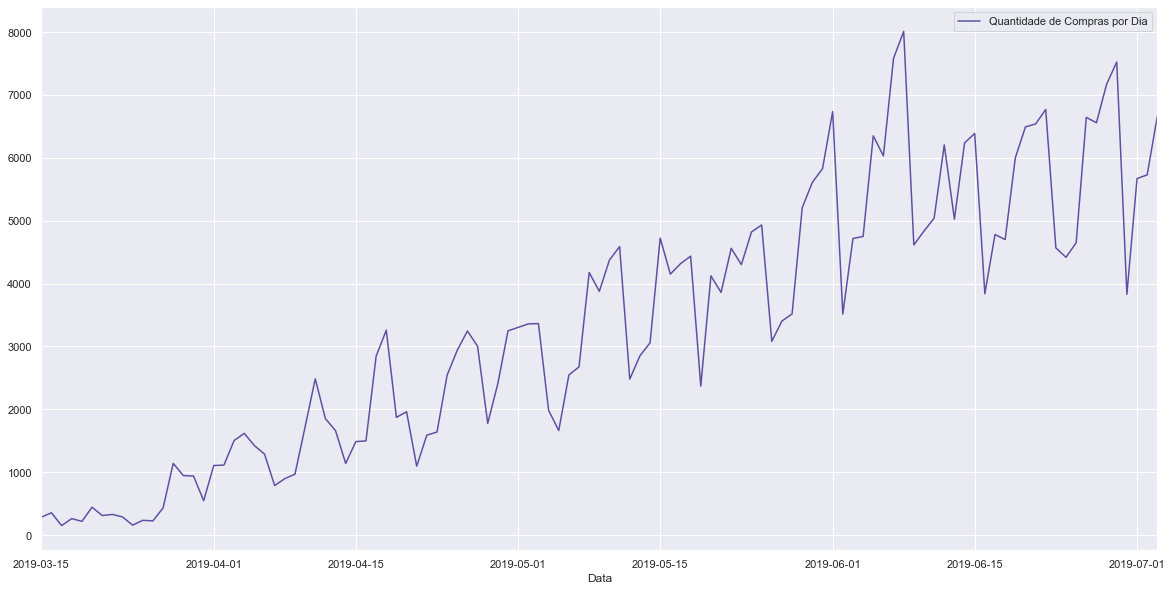

In [9]:
# nbi:hide_in
df_cont.plot(y='Vendas',figsize=(20,10),color=plt.cm.Spectral(300),label='Quantidade de Compras por Dia')

### Vendas por Hora

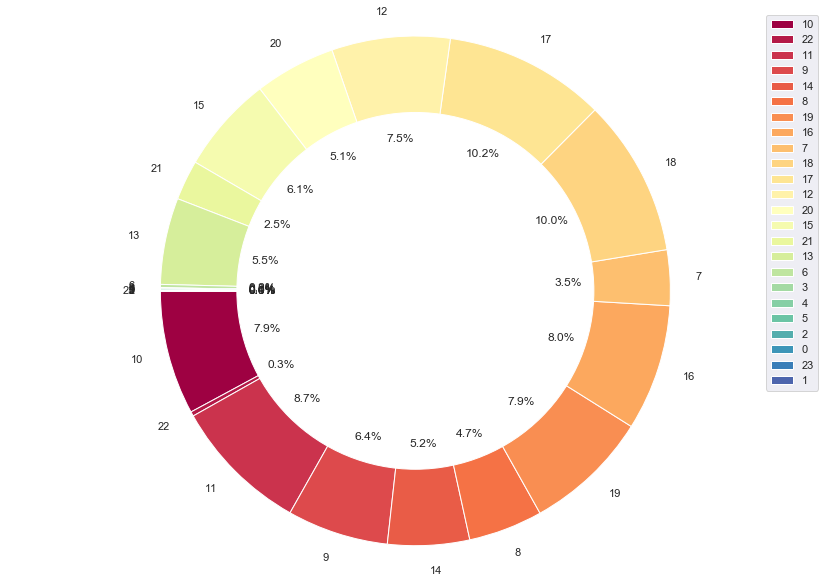

In [24]:
pie_chart(df_vendas,'Hora',180)

### Vendas por Dia da Semana

In [25]:
# nbi:hide_in
# nbi:hide_out
# - Conta para dia da semana
df_semana = pd.DataFrame(df_vendas['Dia da Semana'].value_counts()).reset_index()
df_semana.columns = ['Dia da Semana','Vendas']

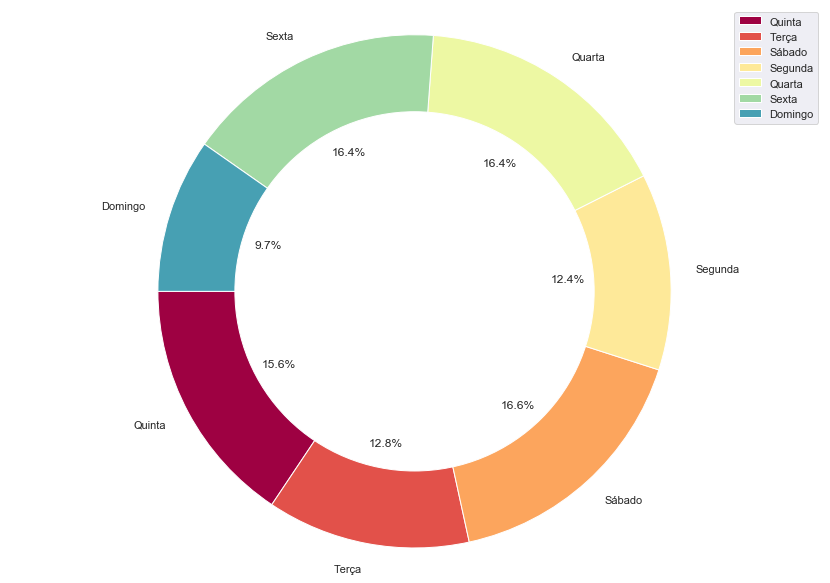

In [27]:
# nbi:hide_in
pie_chart(df_vendas,'Dia da Semana',180)

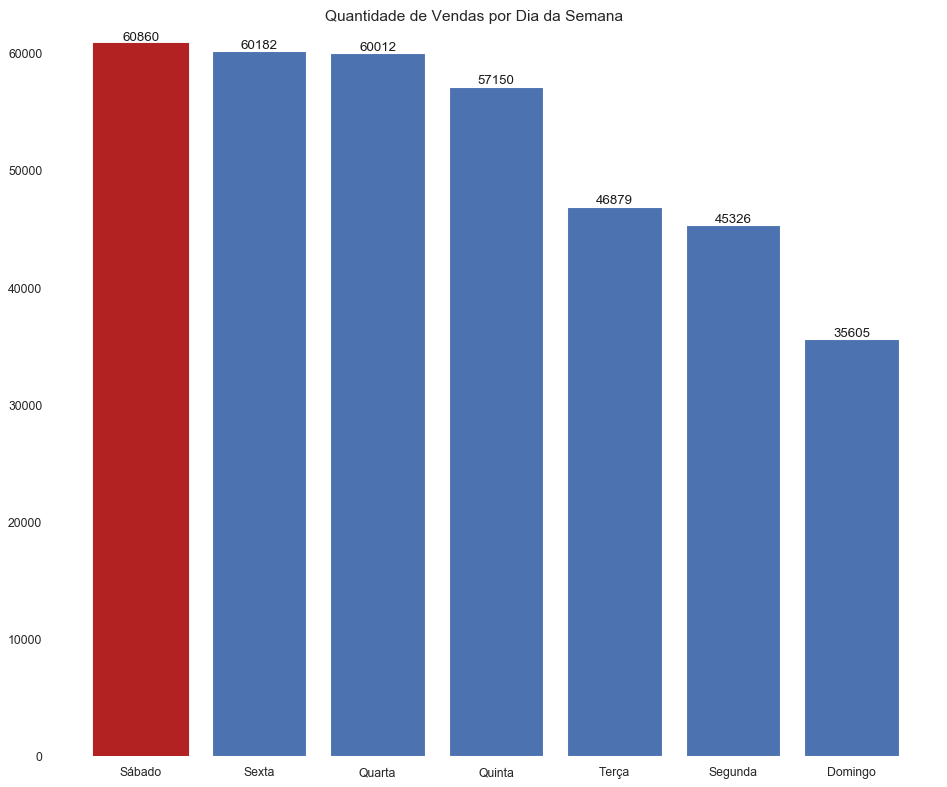

In [28]:
# nbi:hide_in
bar_plot_count(df_semana,'Dia da Semana','Vendas','Quantidade de Vendas por Dia da Semana')

### Vendas por Mês

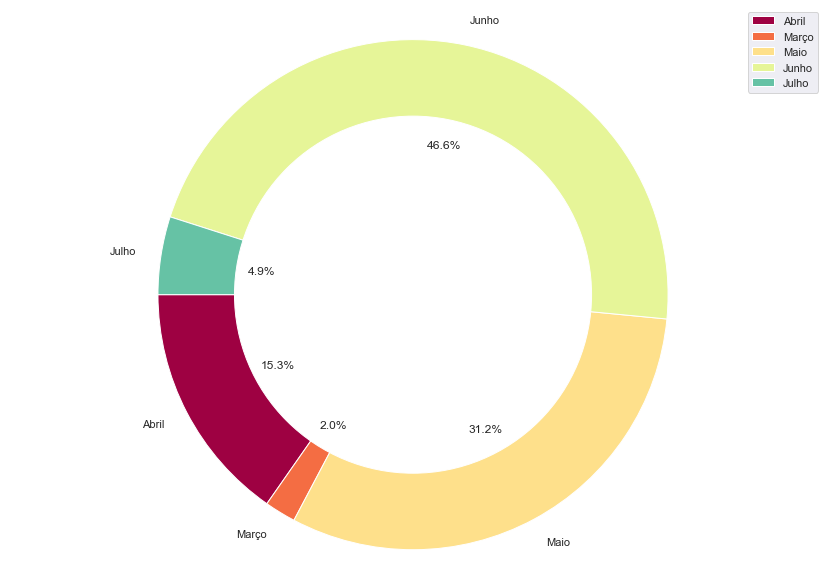

In [30]:
pie_chart(df_vendas,'Mês',180)

## Previsão

### Lag Plot Quantidade de Compras

- Previsão
    - **Lag Plot:**
      Um tipo útil de gráfico para explorar a relação entre cada observação e um atraso dessa observação é o chamado de gráfico de dispersão (scatter plot).
      Pandas tem uma função interna para exatamente isso chamada de lag plot. Faz o gráfico da observação no tempo t no eixo x e na observação lag1 (t-1) no eixo y.
        - Se os pontos se agruparem ao longo de uma linha diagonal da parte inferior esquerda para a parte superior direita da plotagem, isso sugere uma relação de correlação positiva.
        - Se os pontos se agruparem ao longo de uma linha diagonal do canto superior esquerdo para o canto inferior direito, isso sugere um relacionamento de correlação negativo.
        - Qualquer relacionamento é bom, pois eles podem ser modelados.
         
         Mais pontos, mais apertados, na linha diagonal sugerem um relacionamento mais forte enquanto mais propagação da linha sugere um relacionamento mais fraco.

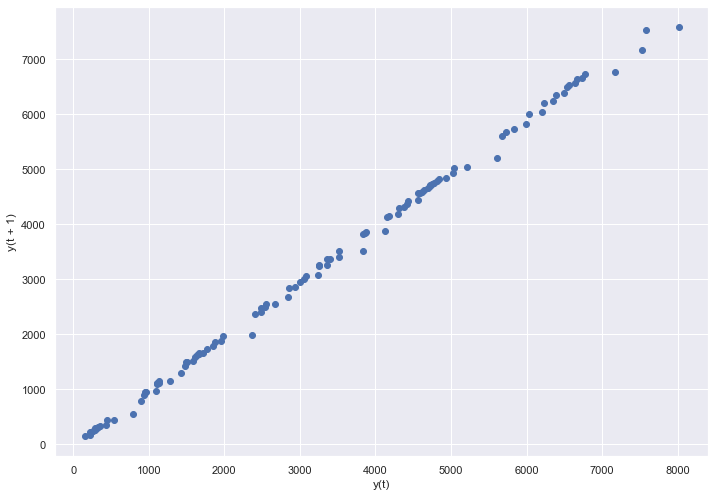

In [10]:
# nbi:hide_in
lag_plot(df_cont)

### Previsão de Compras

In [11]:
# nbi:hide_in
# nbi:hide_out
df_cont = df_cont.reset_index()
df_cont = df_cont.rename(index=str, columns={"Data": "ds", "Vendas": "y"})

In [12]:
# nbi:hide_in
# nbi:hide_out
m = Prophet(growth="linear",seasonality_mode="additive")
m.fit(df_cont)
future = m.make_future_dataframe(periods=10)
prev = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


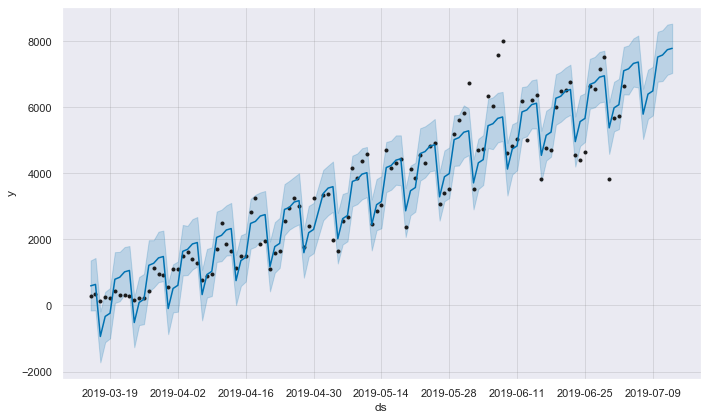

In [13]:
# nbi:hide_in
fig1 = m.plot(prev)

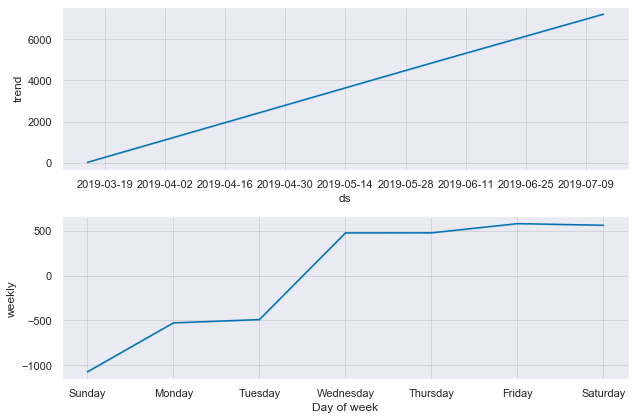

In [14]:
# nbi:hide_in
fig2 = m.plot_components(prev)